In [1]:
import os
import numpy as np
import keras
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices()) 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17771021086173957346
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18129067322066612789
physical_device_desc: "device: XLA_CPU device"
]


### Формируем DataSet

In [3]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "data/train",
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=(224, 224),
    batch_size=32,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "data/val",
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=(224, 224),
    batch_size=32,
)

Found 245 files belonging to 2 classes.
Using 196 files for training.
Found 153 files belonging to 2 classes.
Using 30 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['ants', 'bees']


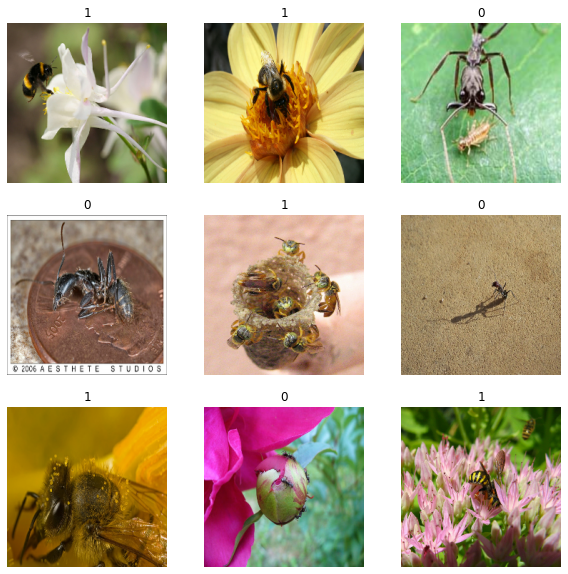

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

(32, 224, 224, 3)
[1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0]


<ipython-input-6-28394bed0472>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(images.shape[0]/4, 4, i+1)


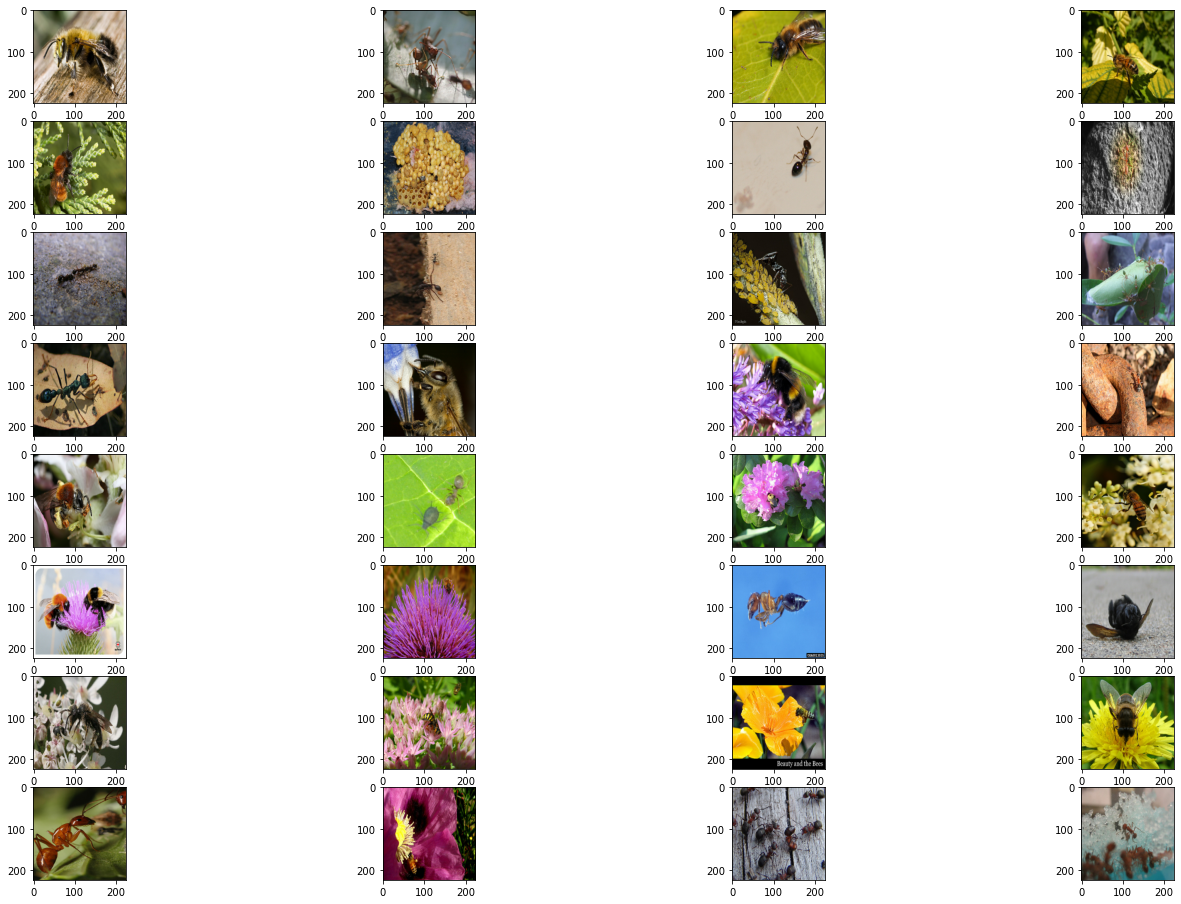

In [6]:
import matplotlib.pyplot as plt


images, classes = next(iter(train_ds))
print(images.shape)
print(classes.numpy())

plt.figure(figsize=(24,16))
for i in range(images.shape[0]):
    plt.subplot(images.shape[0]/4, 4, i+1)
    plt.imshow(images[i]/255)

## Задача 1

Реализуйте сверточную нейронную сеть с использованием tf.keras или keras. Используйте сверточные, пуллинговые и полносвязанные слои. Обучите на train выборке в течении 10 эпох, оцените качество на отложенной выборке

**Нормализуем данные**

Значения канала RGB находятся в диапазоне [0, 255]. Для нейронной сети следует стремиться к тому, чтобы входные значения были небольшими и находились в диапазоне [0, 1]. Для этого используем слой Rescaling.

In [7]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [8]:
#способ 1
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# значения пикселей находятс в диапазоне [0,1]
print(np.min(first_image), np.max(first_image)) 

0.0 0.9768256


In [9]:
num_classes = 2
batch_size = 8
img_height = 224
img_width = 224


model = keras.Sequential([
  #способ 2  
  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),#нормализация
    
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),#сверточный слой в 2-мерном случае
  #16 - число ядер (каналов)
  #3 - размер ядра
  #padding='same'-чтобы сохранить исходные размеры изображения (добавляет на границах нулевые значения)
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),#укрупняем масштаб
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),
  #pool_size=(3,3)-размер окна 3х3
  #strides=3 сдвигаем на 3 (чтобы рамка при сдвиге не пересекалась) 
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),
  #теперь задача весь этот тензор подать на полносвязанную нейронную сеть
  #для этого вытянем тензор в вектор
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)#сколько классов на выходе
])

In [10]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

In [12]:
epochs=10

history1 = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    ) 

Epoch 1/10
7/7 [==============================] - 1s 206ms/step - loss: 0.8980 - accuracy: 0.5255 - val_loss: 0.7173 - val_accuracy: 0.4667
Epoch 2/10
7/7 [==============================] - 1s 192ms/step - loss: 0.7007 - accuracy: 0.4745 - val_loss: 0.6882 - val_accuracy: 0.5333
Epoch 3/10
7/7 [==============================] - 1s 187ms/step - loss: 0.6905 - accuracy: 0.5765 - val_loss: 0.6904 - val_accuracy: 0.6333
Epoch 4/10
7/7 [==============================] - 1s 194ms/step - loss: 0.6796 - accuracy: 0.6429 - val_loss: 0.6779 - val_accuracy: 0.5667
Epoch 5/10
7/7 [==============================] - 1s 188ms/step - loss: 0.6669 - accuracy: 0.5561 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 1s 187ms/step - loss: 0.6474 - accuracy: 0.6786 - val_loss: 0.6985 - val_accuracy: 0.6000
Epoch 7/10
7/7 [==============================] - 1s 189ms/step - loss: 0.6352 - accuracy: 0.6378 - val_loss: 0.7532 - val_accuracy: 0.4667
Epoch 8/10
7/7 [====

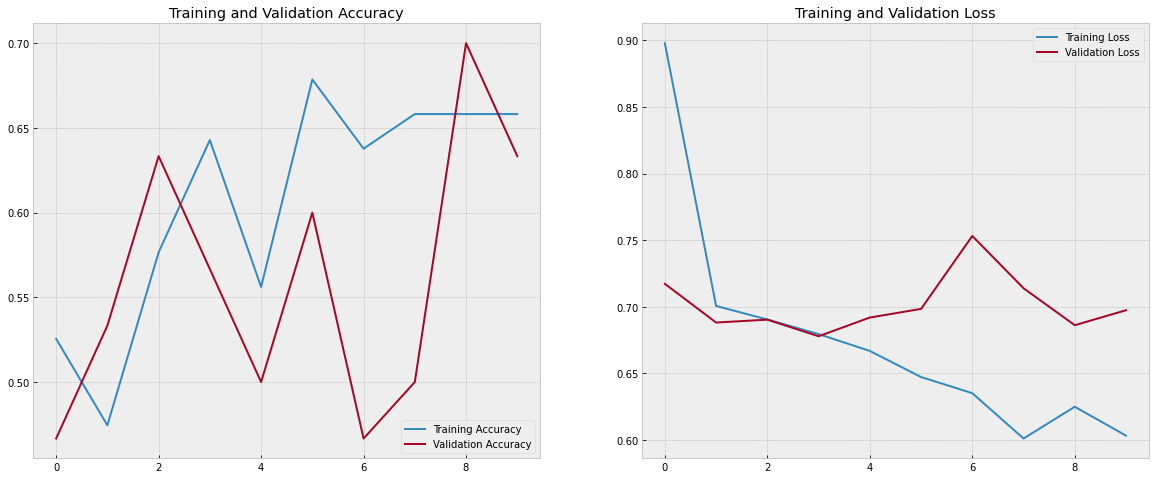

In [13]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Точность на этапе обучения почти повторяет точность на этапе проверки. Точность модели колеблится от 50% до 70%. Увеличим количество эпох.

In [15]:
epochs=30

history1 = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    ) 

Epoch 1/30
7/7 [==============================] - 1s 192ms/step - loss: 0.5293 - accuracy: 0.7806 - val_loss: 0.6900 - val_accuracy: 0.7000
Epoch 2/30
7/7 [==============================] - 1s 193ms/step - loss: 0.5000 - accuracy: 0.7347 - val_loss: 0.7375 - val_accuracy: 0.6667
Epoch 3/30
7/7 [==============================] - 1s 186ms/step - loss: 0.4556 - accuracy: 0.7653 - val_loss: 0.7141 - val_accuracy: 0.6667
Epoch 4/30
7/7 [==============================] - 1s 190ms/step - loss: 0.4124 - accuracy: 0.8418 - val_loss: 0.8445 - val_accuracy: 0.5333
Epoch 5/30
7/7 [==============================] - 1s 187ms/step - loss: 0.4027 - accuracy: 0.8163 - val_loss: 0.8629 - val_accuracy: 0.5000
Epoch 6/30
7/7 [==============================] - 1s 189ms/step - loss: 0.4192 - accuracy: 0.8163 - val_loss: 0.7440 - val_accuracy: 0.5667
Epoch 7/30
7/7 [==============================] - 1s 189ms/step - loss: 0.3720 - accuracy: 0.8367 - val_loss: 0.8214 - val_accuracy: 0.6333
Epoch 8/30
7/7 [====

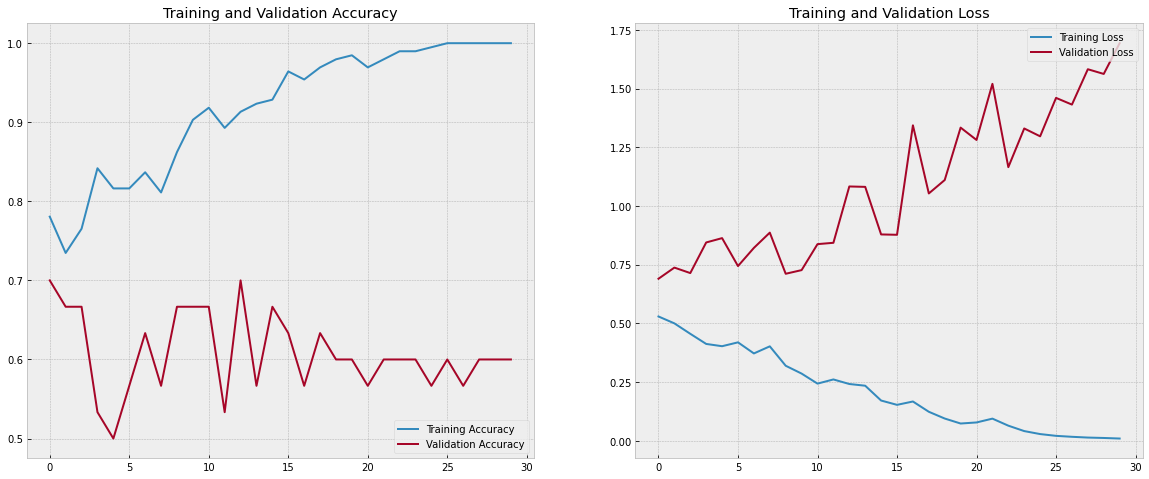

In [16]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Точность модели на этапе проверки, после 16 эплохи усреднилась и состовляет 60%, что значительно отличается от точности получившейся при обучении модели. Функция потерь начинает увеличиваться после 10 эпохи.

## Задание 2

Добавьте в предыдущую архитектуру слои BatchNorm. Обучите на train выборке в течении 10 эпох, оцените качество на отложенной выборке

In [34]:
from keras.layers.normalization import BatchNormalization #уменьшает ковариационный сдвиг

num_classes = 2
batch_size = 8
img_height = 224
img_width = 224


model2 = keras.Sequential([

  keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),#нормализация   
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),#сверточный слой в 2-мерном случае
  #16 - число ядер (каналов)
  #3 - размер ядра
  #padding='same'-чтобы сохранить исходные размеры изображения (добавляет на границах нулевые значения)
  keras.layers.BatchNormalization(),  
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),#укрупняем масштаб
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(3,3), strides=3),
 
  #теперь задача весь этот тензор подать на полносвязанную нейронную сеть
  #для этого вытянем тензор в вектор
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)#сколько классов на выходе
])

In [35]:
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_15 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)       

In [37]:
epochs=10

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 2s 273ms/step - loss: 1.5381 - accuracy: 0.4949 - val_loss: 0.6891 - val_accuracy: 0.5333
Epoch 2/10
7/7 [==============================] - 2s 263ms/step - loss: 0.6602 - accuracy: 0.6224 - val_loss: 0.7029 - val_accuracy: 0.4667
Epoch 3/10
7/7 [==============================] - 2s 264ms/step - loss: 0.6509 - accuracy: 0.6071 - val_loss: 0.7019 - val_accuracy: 0.4333
Epoch 4/10
7/7 [==============================] - 2s 260ms/step - loss: 0.6091 - accuracy: 0.6582 - val_loss: 0.7081 - val_accuracy: 0.4333
Epoch 5/10
7/7 [==============================] - 2s 266ms/step - loss: 0.5840 - accuracy: 0.6888 - val_loss: 0.7217 - val_accuracy: 0.4333
Epoch 6/10
7/7 [==============================] - 2s 272ms/step - loss: 0.5797 - accuracy: 0.6735 - val_loss: 0.7082 - val_accuracy: 0.4333
Epoch 7/10
7/7 [==============================] - 2s 259ms/step - loss: 0.5341 - accuracy: 0.7449 - val_loss: 0.7176 - val_accuracy: 0.4667
Epoch 8/10
7/7 [====

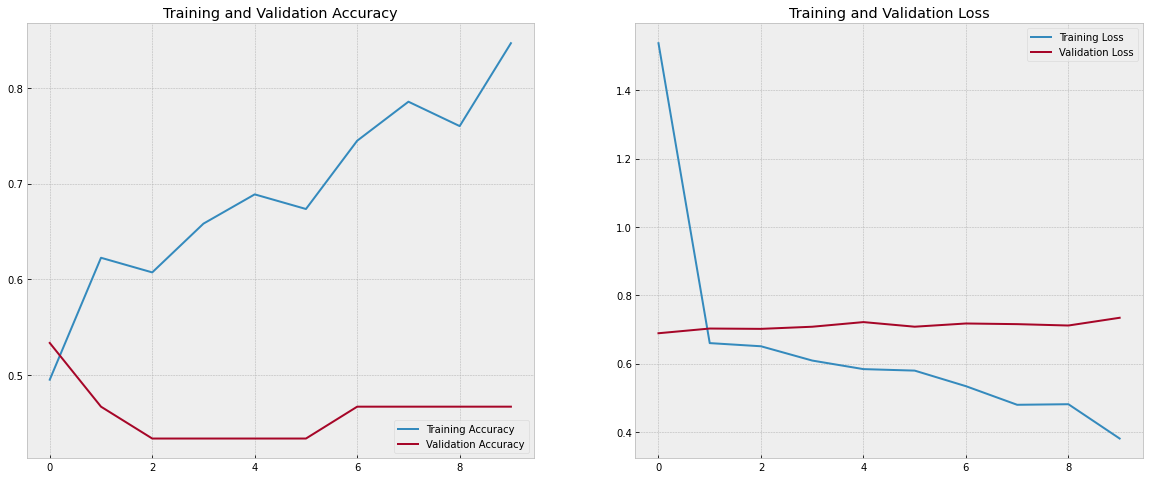

In [38]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

После добавлений слоя BatchNorm показатели модели ухудшились, но график стал плавнее из-за уменьшения ковариационного сдвига. 

## Задача 3

Создайте модель ResNet 50 (https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50), инициализированную случайными весами, и обучите ее на train выборке в течении 10 эпох, оцените качество на отложенной выборке

In [39]:
# создаем модель и загружаем веса
model3=keras.applications.ResNet50(
     weights=None, classes=2
)

In [40]:
model3.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [42]:
epochs=10

history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 30s 4s/step - loss: 0.7643 - accuracy: 0.5408 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 2/10
7/7 [==============================] - 29s 4s/step - loss: 0.7791 - accuracy: 0.5204 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 3/10
7/7 [==============================] - 28s 4s/step - loss: 0.7797 - accuracy: 0.5306 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 4/10
7/7 [==============================] - 29s 4s/step - loss: 0.7268 - accuracy: 0.5867 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 5/10
7/7 [==============================] - 28s 4s/step - loss: 0.7196 - accuracy: 0.5867 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 6/10
7/7 [==============================] - 28s 4s/step - loss: 0.6866 - accuracy: 0.6276 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 7/10
7/7 [==============================] - 28s 4s/step - loss: 0.7197 - accuracy: 0.5918 - val_loss: 0.7799 - val_accuracy: 0.5333
Epoch 8/10
7/7 [==================

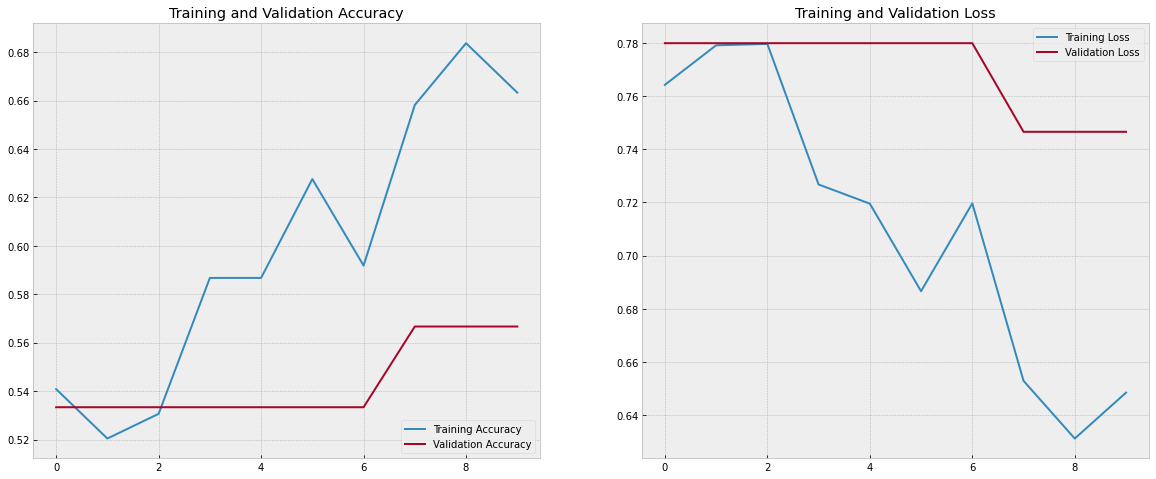

In [43]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

ResNet 50 со случайными весами, после 4ой эпохи, дает стабильный результат с уменьшением функции потерь после 6ой эпохи.

## Задача 4

Создайте модель ResNet 50, инициализированную весами ImageNet, и обучите ее на train выборке в течении 10 эпох, оцените качество на отложенной выборке

In [50]:
# создаем модель и загружаем веса
model4=keras.applications.ResNet50(input_shape=(224, 224, 3),
     weights='imagenet', include_top=False, classes=2
)

x = model4.output
x = keras.layers.GlobalMaxPooling2D()(x)
#x = keras.layers.Dropout(0.7)(x)

predictions = keras.layers.Dense(num_classes, activation='relu')(x)

model4 = keras.Model(inputs = model4.input, outputs = predictions)

In [51]:
model4.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [52]:
model4.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [53]:
epochs=10

history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 28s 4s/step - loss: 3.5744 - accuracy: 0.5969 - val_loss: 7.5218 - val_accuracy: 0.5333
Epoch 2/10
7/7 [==============================] - 29s 4s/step - loss: 2.7897 - accuracy: 0.4643 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 3/10
7/7 [==============================] - 28s 4s/step - loss: 1.1694 - accuracy: 0.5306 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 4/10
7/7 [==============================] - 29s 4s/step - loss: 1.0336 - accuracy: 0.5153 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 5/10
7/7 [==============================] - 28s 4s/step - loss: 1.0513 - accuracy: 0.5102 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 6/10
7/7 [==============================] - 28s 4s/step - loss: 0.8722 - accuracy: 0.5153 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 7/10
7/7 [==============================] - 29s 4s/step - loss: 1.0570 - accuracy: 0.4847 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 8/10
7/7 [==================

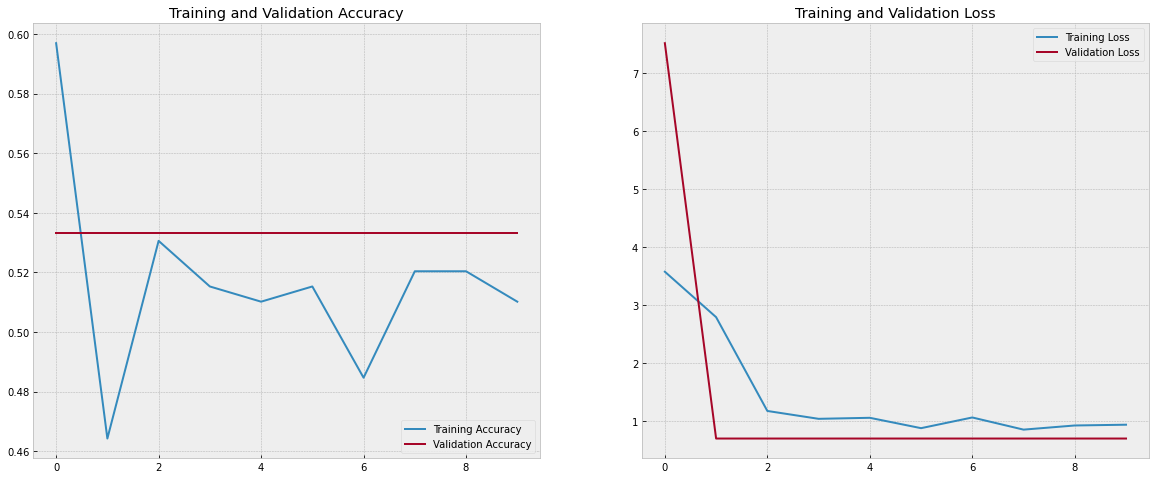

In [54]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

ResNet 50 с инициализированными весами ImageNet, показал самый стабильный результат. После первой эпохи функция потерь уменьшилась и больше не поднималась.